In [2]:
import tensorflow as tf #type : ignore
from tensorflow.keras import layers #type : ignore
 
from keras.preprocessing.image import ImageDataGenerator #type : ignore

import os
import shutil
import numpy as np #type : ignore

In [3]:
# old_dir = 'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset/'
# new_dir_train = 'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain/'
# new_dir_test = 'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTest/'

In [22]:
import os
import shutil
import random

def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    
    Args:
        filename (str): The name of the file.
        
    Returns:
        bool: True if the file is an image, False otherwise.
    """
    image_extensions = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'}
    return os.path.splitext(filename)[1].lower() in image_extensions

# Path to the original dataset directory
dataset_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset'

# Paths to the new train and test directories
train_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain'
test_dir = r'D:\MSIB BANGKIT (6) 2024\Capstone\C_Project/HikingDatasetTest'

# Create the new train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each folder in the dataset directory
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    
    if not os.path.isdir(folder_path) or folder == ".DS_Store":
        continue

    # Paths for the corresponding train and test subdirectories
    train_subdir = os.path.join(train_dir, folder)
    test_subdir = os.path.join(test_dir, folder)

    # Create the train and test subdirectories
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if is_image_file(f)]

    # Shuffle the files to ensure random splitting
    random.shuffle(image_files)

    # Calculate split index
    split_index = int(len(image_files) * 0.8)

    # Split the files into train and test sets
    train_files = image_files[:split_index]
    test_files = image_files[split_index:]

    # Copy files to the train and test directories
    for file in train_files:
        src_file = os.path.join(folder_path, file)
        train_file = os.path.join(train_subdir, file)
        try:
            shutil.copy2(src_file, train_file)
            print(f"Copied {src_file} to {train_file}")
        except Exception as e:
            print(f"Error copying {src_file} to {train_file}: {e}")

    for file in test_files:
        src_file = os.path.join(folder_path, file)
        test_file = os.path.join(test_subdir, file)
        try:
            shutil.copy2(src_file, test_file)
            print(f"Copied {src_file} to {test_file}")
        except Exception as e:
            print(f"Error copying {src_file} to {test_file}: {e}")


Copied D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset\air mineral\images - 2024-06-06T110802.491.jpg to D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain\air mineral\images - 2024-06-06T110802.491.jpg
Copied D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset\air mineral\20005529_1 (1).jpg to D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain\air mineral\20005529_1 (1).jpg
Copied D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset\air mineral\images - 2024-06-06T110734.860.jpg to D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain\air mineral\images - 2024-06-06T110734.860.jpg
Copied D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset\air mineral\images - 2024-06-06T110731.847.jpg to D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain\air mineral\images - 2024-06-06T110731.847.jpg
Copied D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset\air mineral\images - 2024-06-06T110711.452.jpg to D:/MSIB BANG

In [23]:
img_height = 224
img_width = 224
batch_size = 32

In [24]:
classes = os.listdir(train_dir)
classes = [c for c in classes if c != ".DS_Store"]
classes

['air mineral', 'jaket gunung', 'lampu senter', 'tas gunung']

In [25]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.5, 1.5),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create a Keras DataGenerator with data augmentation
train_ds = datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes
)

val_ds = datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes
)

Found 2477 images belonging to 4 classes.
Found 617 images belonging to 4 classes.


In [26]:
test_datagen = ImageDataGenerator(
)

test_ds = datagen.flow_from_directory(
    test_dir, 
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes

)

Found 774 images belonging to 4 classes.


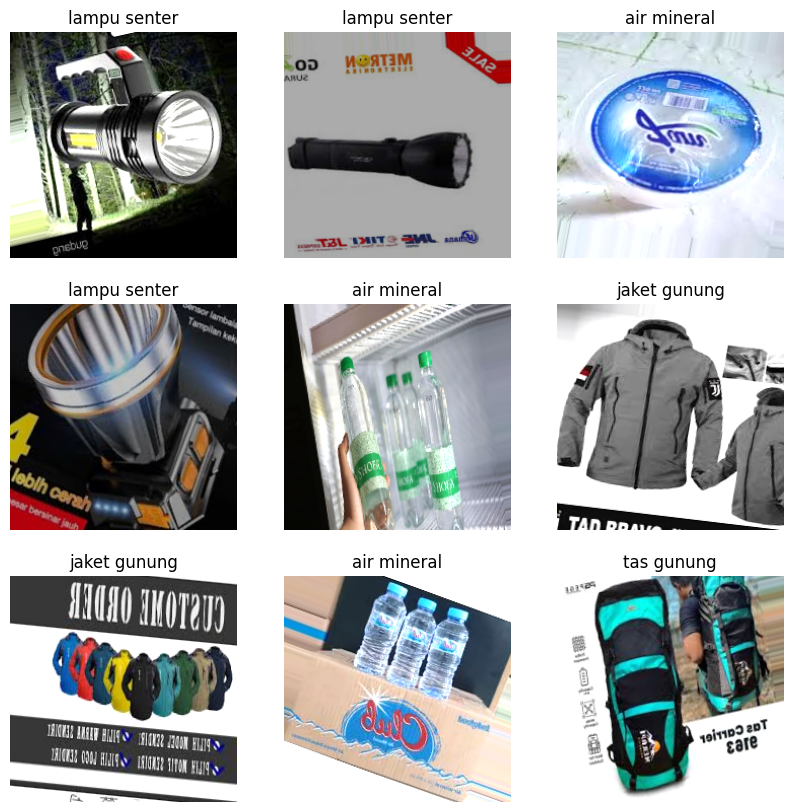

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

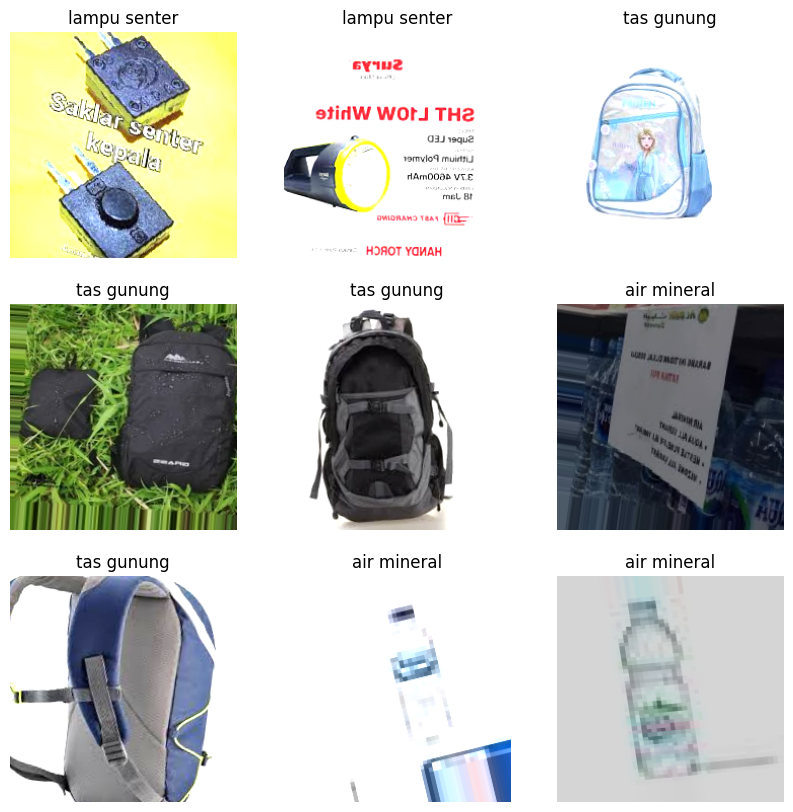

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

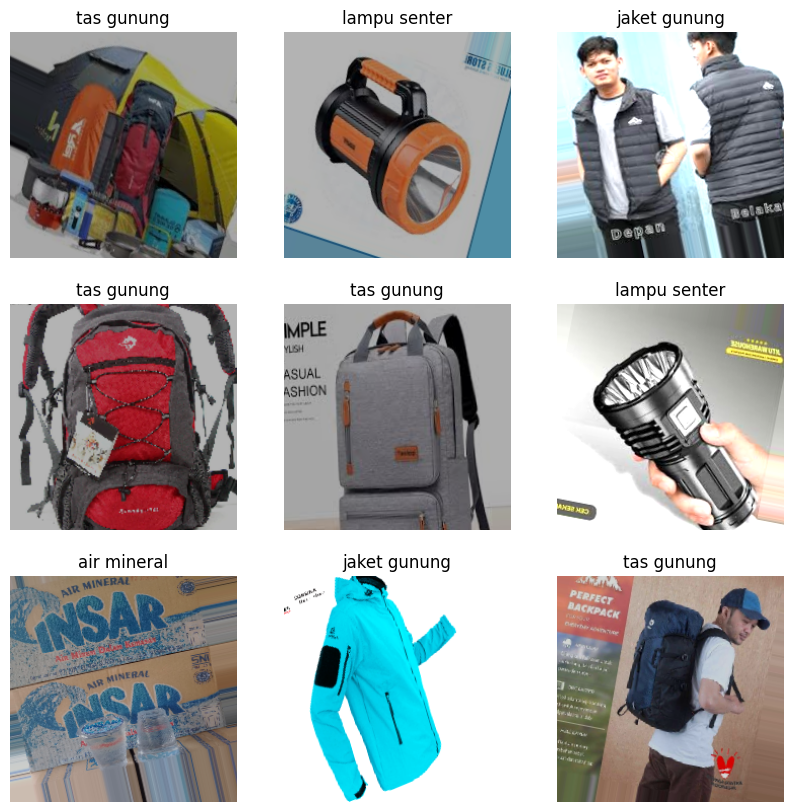

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

In [30]:
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg'
)
out = tf.keras.layers.Dense(len(classes))(resnet.output)
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 10
checkpoint_filepath = 'models/resnet50'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[model_checkpoint_callback])


Epoch 1/10


78/78 [==============================] - ETA: 0s - loss: 1.0305 - accuracy: 0.6774INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


78/78 [==============================] - 348s 4s/step - loss: 1.0305 - accuracy: 0.6774 - val_loss: 30.0866 - val_accuracy: 0.1994
Epoch 2/10
78/78 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8159INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


78/78 [==============================] - 328s 4s/step - loss: 0.5064 - accuracy: 0.8159 - val_loss: 45.4017 - val_accuracy: 0.4473
Epoch 3/10
78/78 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8438INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


78/78 [==============================] - 353s 5s/step - loss: 0.4124 - accuracy: 0.8438 - val_loss: 3.3085 - val_accuracy: 0.5219
Epoch 4/10
78/78 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8761INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


78/78 [==============================] - 359s 5s/step - loss: 0.3410 - accuracy: 0.8761 - val_loss: 0.8718 - val_accuracy: 0.7618
Epoch 5/10
78/78 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8874INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


78/78 [==============================] - 328s 4s/step - loss: 0.3047 - accuracy: 0.8874 - val_loss: 0.8957 - val_accuracy: 0.7828
Epoch 6/10
78/78 [==============================] - 304s 4s/step - loss: 0.2818 - accuracy: 0.9047 - val_loss: 1.3578 - val_accuracy: 0.6337
Epoch 7/10
78/78 [==============================] - 814s 11s/step - loss: 0.2568 - accuracy: 0.9027 - val_loss: 0.9146 - val_accuracy: 0.7796
Epoch 8/10
78/78 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9277INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


78/78 [==============================] - 343s 4s/step - loss: 0.2040 - accuracy: 0.9277 - val_loss: 0.4522 - val_accuracy: 0.8331
Epoch 9/10
78/78 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9338INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


78/78 [==============================] - 337s 4s/step - loss: 0.1916 - accuracy: 0.9338 - val_loss: 0.3550 - val_accuracy: 0.8930
Epoch 10/10
78/78 [==============================] - 340s 4s/step - loss: 0.2029 - accuracy: 0.9265 - val_loss: 0.4700 - val_accuracy: 0.8558


In [32]:
new_model = tf.keras.models.load_model('models/resnet50/')

In [33]:
new_model.evaluate(train_ds)

78/78 [==============================] - 108s 1s/step - loss: 0.3561 - accuracy: 0.8870


[0.356115460395813, 0.8869600296020508]

In [34]:
new_model.evaluate(val_ds)

20/20 [==============================] - 28s 1s/step - loss: 0.4140 - accuracy: 0.8784


[0.41400203108787537, 0.8784440755844116]

In [35]:
new_model.evaluate(test_ds)

25/25 [==============================] - 38s 2s/step - loss: 0.5324 - accuracy: 0.8501


[0.5323605537414551, 0.8501291871070862]